# Imports

In [14]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time as time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat
import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor
import pickle
from sklearn.model_selection import ShuffleSplit
import transformers
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
from matplotlib import pyplot as plt

# MODELE

In [2]:


class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')


class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()

        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)

        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5)
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)

    def forward(self, x, edge_index, edge_attr, batch):
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x



class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, segment, age
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        #self.word_embeddings = nn.Linear(config.vocab_size, config.hidden_size)
        self.word_embeddings = GraphTransformer(config)
        self.type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size//5)
        self.age_embeddings = nn.Embedding(config.age_vocab_size, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.age_vocab_size, config.hidden_size//5))
        self.time_embeddings = nn.Embedding(config.time_vocab_size , config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.time_vocab_size, config.hidden_size//5))
        self.posi_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.max_position_embeddings, config.hidden_size//5))


        self.seq_layers = nn.Sequential(
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU()
        )

        self.LayerNorm = nn.LayerNorm(config.hidden_size)
        self.acti = nn.GELU()
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

    def forward(self, nodes, edge_index,  edge_attr, batch, age_ids, time_ids,  type_ids, posi_ids):
        word_embed = self.word_embeddings(nodes, edge_index, edge_attr, batch)
        type_embeddings = self.type_embeddings(type_ids)
        age_embed = self.age_embeddings(age_ids)
        time_embeddings = self.time_embeddings(time_ids)
        posi_embeddings = self.posi_embeddings(posi_ids)

        word_embed = torch.reshape(word_embed, type_embeddings.shape)
        embeddings = torch.cat((word_embed, type_embeddings, posi_embeddings, age_embed, time_embeddings), dim=2)
        
        b, n, _ = embeddings.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)
        embeddings = self.seq_layers(embeddings)
        embeddings = self.LayerNorm(embeddings)
        
        return embeddings

    def _init_posi_embedding(self, max_position_embedding, hidden_size):
        def even_code(pos, idx):
            return np.sin(pos / (10000 ** (2 * idx / hidden_size)))

        def odd_code(pos, idx):
            return np.cos(pos / (10000 ** (2 * idx / hidden_size)))

        # initialize position embedding table
        lookup_table = np.zeros((max_position_embedding, hidden_size), dtype=np.float32)

        # reset table parameters with hard encoding
        # set even dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(0, hidden_size, step=2):
                lookup_table[pos, idx] = even_code(pos, idx)
        # set odd dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(1, hidden_size, step=2):
                lookup_table[pos, idx] = odd_code(pos, idx)

        return torch.tensor(lookup_table)



class BertModel(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config=config)
        self.encoder = Bert.modeling.BertEncoder(config=config)
        self.pooler = Bert.modeling.BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, output_all_encoded_layers=True):

        if attention_mask is None:
            attention_mask = torch.ones_like(age_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids)
        encoded_layers = self.encoder(embedding_output, extended_attention_mask, output_all_encoded_layers=output_all_encoded_layers)
        
        sequence_output = encoded_layers[-1]

        pooled_output = self.pooler(sequence_output)
        
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]

        return encoded_layers, pooled_output




class BertForMTR(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertForMTR, self).__init__(config)
        self.num_labels = 1
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, labels=None):
        encoded_layer, pooled_output = self.bert(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask, output_all_encoded_layers=False)

        logits = self.classifier(pooled_output).squeeze(dim=1)
        
        weights = torch.where(labels == 1, torch.tensor(1.5), torch.tensor(1.0))  #### à voir
        bce_logits_loss = nn.BCEWithLogitsLoss(reduction='mean', weight=weights)
        discr_supervised_loss = bce_logits_loss(logits, labels)
        
        return encoded_layer, pooled_output, logits, discr_supervised_loss
    

    

class Pre_training2(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(Pre_training2, self).__init__(config)
        self.bert = BertForMTR(config)
        self.linear1 = nn.Linear(config.hidden_size, self.config.vocab_size)
        self.linear2 = nn.Linear(config.hidden_size, self.config.type_vocab_size -1)
        self.gru = nn.GRU(config.hidden_size, config.hidden_size  , 1, batch_first = True, bidirectional=False)
        self.apply(self.init_bert_weights)
    
    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, labels=None):
        encoded_layer, pooled_output, logits, discr_supervised_loss = self.bert(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask, labels)
        pooled_output = pooled_output.unsqueeze(dim=1)

        hidden = None
        output_sequence = []
        nb_seq = 50
        for i in range(nb_seq):
            output,hidden = self.gru(pooled_output, hidden)
            output_sequence.append(output)
        output_sequence = torch.stack(output_sequence, dim=1).squeeze(dim=2)
        
        b,s,h = output_sequence.shape
        output_sequence = output_sequence.view(b*s,h)
        output_sequence1 = self.linear1(output_sequence)
        output_sequence2 = self.linear2(output_sequence)
        
        return output_sequence1,output_sequence2



class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')



class TrainConfig(object):
    def __init__(self, config):
        self.batch_size = config.get('batch_size')
        self.max_len_seq = config.get('max_len_seq')
        self.train_loader_workers = config.get('train_loader_workers')
        self.test_loader_workers = config.get('test_loader_workers')
        self.device = config.get('device')
        self.output_dir = config.get('output_dir')
        self.output_name = config.get('output_name')
        self.best_name = config.get('best_name')



class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

# DATA

In [3]:
path = '../../data/'
path_results = '../../results/'

In [4]:
with open(path + 'data_pad100.pkl', 'rb') as handle:
    dataset_loaded = pickle.load(handle)

In [5]:
#dataset = dataset_loaded[:100]

In [6]:
#with open('data_pad100', "wb") as f:
    #pickle.dump(dataset, f)

In [7]:
dataset=dataset_loaded

In [8]:
print(len(dataset))
print(len(dataset[0]))
print(dataset[0][-1])

100
50
Data(subject_id=[1], hadm_id=[1], label=[1], age=[1], rang=[1], type=[1], x=[56], edge_index=[2, 1540], edge_attr=[1540], mask_v=[1], time=[1])


In [9]:
noeud_unique = set()
edge_attr_unique = set()
age_unique = set()
time_unique = set()
type_unique = set()
label_unique = set()
hadm_unique = set()
subject_unique = set()
mask_v_unique = set()
rang_unique = set()
for patient in dataset:
    for visite in patient:
        noeuds = visite.x.tolist()
        edge = visite.edge_attr.tolist()
        label = visite.label.tolist()
        age = visite.age.tolist()
        time = visite.time.tolist()
        typ = visite.type.tolist()
        mask_v = visite.mask_v.tolist()
        rang = visite.rang.tolist()
        hadm = visite.hadm_id.tolist()
        subject = visite.subject_id.tolist()
        for noeud in noeuds:
            noeud_unique.add(noeud)
        for attribut in edge:
            edge_attr_unique.add(attribut)
        for lab in label:
            label_unique.add(lab)
        for a in age:
            age_unique.add(a)
        for t in time:
            time_unique.add(t)
        for ty in typ:
            type_unique.add(ty)
        for mask in mask_v:
            mask_v_unique.add(mask)
        for r in rang:
            rang_unique.add(r)
        for h in hadm:
            hadm_unique.add(h)
        for s in subject:
            subject_unique.add(s)
        

vocab_size = len(noeud_unique)
edge_attr_size = len(edge_attr_unique)
age_size = len(age_unique)
time_size = len(time_unique)
type_size = len(type_unique)
label_size = len(label_unique)
hadm_size = len(hadm_unique)
subject_size = len(subject_unique)
mask_v_size = len(mask_v_unique)
rang_size = len(rang_unique)

print('vocab_size',vocab_size)
print('max noeud',max(noeud_unique))
print('node_attr_size',edge_attr_size)
print('max edge_attr',max(edge_attr_unique))
print('age_size',age_size)
print('max age',max(age_unique))
print('time_size',time_size)
print('max time',max(time_unique))
print('type_size',type_size)
print('max type',max(type_unique))
print('label_size',label_size)
print('max label',max(label_unique))
print('hadm_size',hadm_size)
print('subject_size',subject_size)
print('maskv_size',mask_v_size)
print('max maskv',max(mask_v_unique))
print('rang_size',rang_size)
print('max rang',max(rang_unique))

vocab_size 1055
max noeud 9377
node_attr_size 8
max edge_attr 7
age_size 48
max age 130
time_size 248
max time 367
type_size 9
max type 10
label_size 2
max label 1
hadm_size 394
subject_size 100
maskv_size 2
max maskv 1
rang_size 24
max rang 51


In [10]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]
      return trainDSet, valDSet, testDSet

# Config file 

In [11]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 3,
    'lr': 0.0001,
    'weight_decay': 0.0001,
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1 , # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels': 1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

# fonction entrainement

In [12]:
import torch
import random
import copy

def creation_edge_index(x):
    # Edges (graphe complet)
    edge_index = []
    all_edges = []

    for i in range(len(x)):
        for j in range(i+1,len(x)):
            all_edges.append((i, j))
    source, target = zip(*all_edges)

    edge_index = torch.tensor([source, target], dtype=torch.int64)

    return edge_index
'''
def remove_nodes(graph_batch, max_nodes_per_visit=3):
    num_nodes = graph_batch.x.size(0)
    num_visits = graph_batch.batch.max() + 1
    graph_batch2 = copy.deepcopy(graph_batch)
    
    nodes_to_keep = []  # Liste pour stocker les nœuds à conserver
    nodes_to_remove = []  # Liste pour stocker les nœuds à supprimer
    to_delete = []
    
    for id, visit_id in enumerate(range(num_visits)):
        visit_nodes = (graph_batch.batch == visit_id).nonzero(as_tuple=False).squeeze()

        num_nodes_in_visit = len(visit_nodes)
        
        if num_nodes_in_visit > max_nodes_per_visit:
            # Choisir un nœud à supprimer au hasard
            node_to_remove = random.choice(visit_nodes.tolist())
            nodes_to_remove.append(node_to_remove)

            # Ajouter tous les nœuds sauf celui à supprimer
            nodes_to_keep.extend(visit_nodes[visit_nodes != node_to_remove].tolist())
            to_delete.append(id)

        else:
            nodes_to_keep.extend(visit_nodes.tolist())
    
    # Supprimer les nœuds
    print(graph_batch2.x.shape)
    graph_batch2.x = graph_batch.x[nodes_to_keep]
    true = graph_batch.x[nodes_to_remove]

     # Supprimer les arêtes associées aux nœuds supprimés
    edge_index = graph_batch.edge_index
    print(edge_index)
    print(edge_index.size(1))
    mask = torch.ones(edge_index.size(1), dtype=torch.bool)
    for node in nodes_to_remove:
        mask = mask & ~((edge_index[0] == node) | (edge_index[1] == node))
    edge_index = edge_index[:, mask]
    
    graph_batch2.edge_index = edge_index

    # Supprimer les attributs d'arête associés aux arêtes supprimées
    graph_batch2.edge_attr = graph_batch2.edge_attr[mask]

    graph_batch2.batch = graph_batch.batch[nodes_to_keep]
   
    return graph_batch2, true, to_delete
'''

def rem_node(data, min_node_per_visit=3):
    dataset2 = []
    nodes_to_remove = []
    indices_to_remove = []
    for i, patient in enumerate(data):
        patient2=[]
        for j, visite in enumerate(patient):
            node_initial = visite.x
            edge_index_initial = visite.edge_index
            edge_attr_initial = visite.edge_attr
            batch_initial = visite.batch
            num_nodes_in_visit = len(visite.x)
            visit2 = copy.deepcopy(visite)
            if num_nodes_in_visit > min_node_per_visit:
                # Choisir un nœud à supprimer au hasard
                node_to_remove = random.choice(node_initial.tolist()[1:])
                nodes_to_remove.append(node_to_remove)
                indices_to_remove.append(True)
                visit2.x = node_initial[node_initial != node_to_remove]
                mask = torch.ones(edge_index_initial.size(1), dtype=torch.bool)
                mask = mask & ~ ((edge_index_initial[0] == node_to_remove) | (edge_index_initial[1] == node_to_remove))
                visit2.edge_index = creation_edge_index(visit2.x)
                visit2.edge_attr = edge_attr_initial[mask]

                patient2.append(visit2)
            else:
                patient2.append(visit2)
                indices_to_remove.append(False)
            
        dataset2.append(patient2)

    return dataset2, torch.tensor(nodes_to_remove, dtype=torch.int64), indices_to_remove




def train(model, optim_model, trainload, device,scheduler=None):
    tr_loss = 0
    start = time.time()
    model.train()
    loss_type= torch.nn.CrossEntropyLoss()
    loss_node = torch.nn.CrossEntropyLoss()

    for step, data in tqdm(enumerate(trainload)):
        optim_model.zero_grad()

        graph_batch, true_node , nodes_to_remove_idx = rem_node(data,3)

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch
        

        # pour le type 
        p = graph_batch.type.shape
        mask_type = (torch.ones(p) * 11).to(torch.int64).to(device)
        true_type = graph_batch.type
        graph_batch.type = mask_type



        age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
        time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
        type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
        posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
        attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
        attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
        labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()


        pred_node, pred_type = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)
        pred_node = pred_node[nodes_to_remove_idx]

        loss1 = loss_type(pred_type, true_type)
        loss2 = loss_node(pred_node, true_node.to(device))
        total_loss = loss1 + loss2

        
        total_loss.backward()
        tr_loss += total_loss.item()
        optim_model.step()
        if scheduler is not None:
            scheduler.step()
        del loss1
        del loss2
        del total_loss
        
    
    print("TOTAL TRAIN LOSS",(tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    print("TRAINING TIME", cost)

    return tr_loss, cost


def eval(model, optim_model, _valload, saving, device):
    tr_loss = 0
    start = time.time()
    model.eval()
    loss_type = nn.CrossEntropyLoss()
    loss_node = nn.CrossEntropyLoss()

    with torch.no_grad():
        for step, data in enumerate(_valload):
            optim_model.zero_grad()

            graph_batch, true_node , nodes_to_remove_idx = rem_node(data,3)

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch
            

            # pour le type 
            p = graph_batch.type.shape
            mask_type = (torch.ones(p) * 11).to(torch.int64).to(device)
            true_type = graph_batch.type
            graph_batch.type = mask_type



            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()


            pred_node, pred_type = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)
            pred_node = pred_node[nodes_to_remove_idx]

            loss1 = loss_type(pred_type, true_type)
            loss2 = loss_node(pred_node, true_node.to(device))
            total_loss = loss1+loss2
            tr_loss += total_loss.item()
            del loss1
            del loss2
            del total_loss

    print("TOTAL VAL LOSS",(tr_loss * train_params['batch_size']) / len(_valload))


    cost = time.time() - start
    print("EVAL TIME", cost)

    return tr_loss, cost


def test(testload, model, device):
    model.eval()
    tr_loss = 0
    start = time.time()
    loss_type = nn.CrossEntropyLoss()
    loss_node = nn.CrossEntropyLoss()
    with torch.no_grad():
        for step, data in enumerate(testload):
            # Process the batch data and move it to the device

            graph_batch, true_node , nodes_to_remove_idx = rem_node(data,3)

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch
            

            # pour le type 
            p = graph_batch.type.shape
            mask_type = (torch.ones(p) * 11).to(torch.int64).to(device)
            true_type = graph_batch.type
            graph_batch.type = mask_type


            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()


            pred_node, pred_type = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)
            pred_node = pred_node[nodes_to_remove_idx]

            loss1 = loss_type(pred_type, true_type)
            loss2 = loss_node(pred_node, true_node.to(device))
            total_loss = loss1 + loss2
            tr_loss += total_loss.item()
            del loss1
            del loss2
            del total_loss

    print("TOTAL TEST LOSS ", (tr_loss * train_params['batch_size']) / len(testload))
    cost = time.time() - start
    print("TEST TEST TIME", cost)
    

    return tr_loss, cost



def run_epoch(model, optim_model, trainload, valload, device, exp, scheduler=None):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []

    for e in range(train_params["epochs"]):
        print("Epoch n" + str(e))

        train_loss, train_time_cost = train(model, optim_model, trainload, device,scheduler)
        val_loss, val_time_cost = eval(model, optim_model, valload, False, device)

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        
        with open(path_results + 'losses_and_times/' + "GT_behrt_log_pretrain_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')

        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.bert.state_dict(), path_results + 'weights/' + 'GraphTransformer_pretrain_2_num_' + f'{exp}' + '.pch')
            best_val = val_loss
        print('\n')
        
        
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'Pre_training_2.png')
    plt.show()
        
        
    return train_loss, val_loss, train_time_cost, val_time_cost



def experiment(num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = Pre_training2(conf).to(train_params['device'])
        
        # taking back the weights of the pretraining 1
        model.bert.bert.embeddings.word_embeddings.load_state_dict(torch.load(path_results + 'weights/' + 'GraphTransformer_pretrain_1_num_' + f'{exp}' + '.pch', map_location=train_params.get('device')))
        
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])
        scheduler = None
    
        print(f"\n Experiment {exp + 1}")
        trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)
        trainload =  GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False)
        valload =  GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)
        testload =  GraphLoader(GDSet(testDSet), batch_size=train_params['batch_size'], shuffle=False)
        #pretrain à ajouter ici
        train_loss, val_loss, train_time_cost, val_time_cost = run_epoch(model, optim_model, trainload, valload, train_params['device'], exp, scheduler)
        test_loss, test_cost = test(testload, model, train_params['device'])

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Time', test_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Loss', test_loss]
        
    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_2.csv')

    return df


def save_model(_model_dict, file_name):
    torch.save(_model_dict, file_name)


# Main

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  5.49it/s]


 Experiment 1
Epoch n0



2it [00:00,  5.78it/s]
3it [00:00,  5.79it/s]
4it [00:00,  5.95it/s]
5it [00:00,  6.13it/s]
6it [00:00,  6.06it/s]
7it [00:01,  6.05it/s]
8it [00:01,  6.02it/s]
9it [00:01,  6.15it/s]
10it [00:01,  5.59it/s]
11it [00:01,  6.00it/s]
12it [00:01,  6.07it/s]
13it [00:02,  6.13it/s]
14it [00:02,  6.31it/s]
15it [00:02,  6.20it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 54.24097474416097
TRAINING TIME 2.4188809394836426
TOTAL VAL LOSS 50.9415340423584
EVAL TIME 0.11347198486328125
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  5.98it/s]
2it [00:00,  6.21it/s]
3it [00:00,  6.13it/s]
4it [00:00,  6.26it/s]
5it [00:00,  6.39it/s]
6it [00:00,  6.29it/s]
7it [00:01,  6.18it/s]
8it [00:01,  6.17it/s]
9it [00:01,  6.26it/s]
10it [00:01,  5.52it/s]
11it [00:01,  5.89it/s]
12it [00:01,  6.05it/s]
13it [00:02,  6.09it/s]
14it [00:02,  6.22it/s]
15it [00:02,  6.23it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 49.31811110178629
TRAINING TIME 2.410736083984375
TOTAL VAL LOSS 46.706225872039795
EVAL TIME 0.12094926834106445
** ** * Saving fine - tuned model ** ** * 


Epoch n2



1it [00:00,  3.52it/s]
2it [00:00,  4.08it/s]
3it [00:00,  4.52it/s]
4it [00:00,  4.94it/s]
5it [00:00,  5.32it/s]
6it [00:01,  5.51it/s]
7it [00:01,  5.55it/s]
8it [00:01,  5.65it/s]
9it [00:01,  5.82it/s]
10it [00:01,  5.35it/s]
11it [00:01,  5.73it/s]
12it [00:02,  5.93it/s]
13it [00:02,  6.02it/s]
14it [00:02,  6.11it/s]
15it [00:02,  5.86it/s]


TOTAL TRAIN LOSS 46.11332480112711
TRAINING TIME 2.56209397315979
TOTAL VAL LOSS 43.76323223114014
EVAL TIME 0.11585688591003418
** ** * Saving fine - tuned model ** ** * 


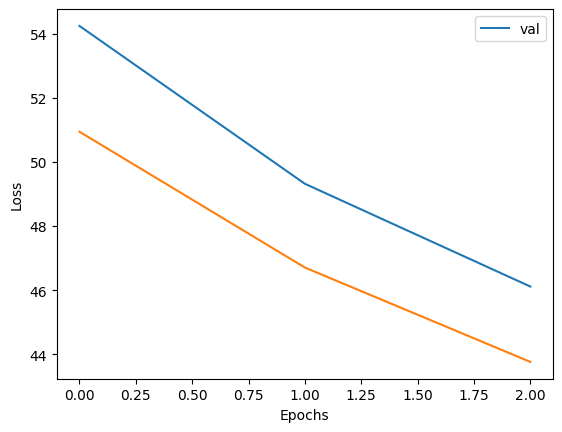

 20%|██        | 1/5 [00:08<00:33,  8.36s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  45.01205086708069
TEST TEST TIME 0.29116177558898926

 Experiment 2
Epoch n0



1it [00:00,  6.37it/s]
2it [00:00,  6.07it/s]
3it [00:00,  6.11it/s]
4it [00:00,  6.17it/s]
5it [00:00,  6.16it/s]
6it [00:00,  6.06it/s]
7it [00:01,  6.16it/s]
8it [00:01,  6.21it/s]
9it [00:01,  5.51it/s]
10it [00:01,  5.63it/s]
11it [00:01,  5.81it/s]
12it [00:02,  5.86it/s]
13it [00:02,  6.01it/s]
14it [00:02,  6.12it/s]
15it [00:02,  6.12it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 53.3254451751709
TRAINING TIME 2.451087236404419
TOTAL VAL LOSS 50.054285526275635
EVAL TIME 0.11439895629882812
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  6.43it/s]
2it [00:00,  6.41it/s]
3it [00:00,  6.32it/s]
4it [00:00,  6.43it/s]
5it [00:00,  6.31it/s]
6it [00:00,  6.19it/s]
7it [00:01,  6.16it/s]
8it [00:01,  6.27it/s]
9it [00:01,  4.11it/s]
10it [00:01,  4.46it/s]
11it [00:02,  4.85it/s]
12it [00:02,  5.12it/s]
13it [00:02,  5.48it/s]
14it [00:02,  5.77it/s]
15it [00:02,  5.69it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 48.40131791432699
TRAINING TIME 2.6368441581726074
TOTAL VAL LOSS 46.75436735153198
EVAL TIME 0.11791014671325684
** ** * Saving fine - tuned model ** ** * 


Epoch n2



1it [00:00,  6.51it/s]
2it [00:00,  6.27it/s]
3it [00:00,  6.34it/s]
4it [00:00,  6.44it/s]
5it [00:00,  6.26it/s]
6it [00:00,  6.10it/s]
7it [00:01,  6.20it/s]
8it [00:01,  6.35it/s]
9it [00:01,  5.50it/s]
10it [00:01,  5.61it/s]
11it [00:01,  5.79it/s]
12it [00:02,  5.84it/s]
13it [00:02,  6.03it/s]
15it [00:02,  6.21it/s]


TOTAL TRAIN LOSS 45.69723002115885
TRAINING TIME 2.4153459072113037
TOTAL VAL LOSS 45.04553556442261
EVAL TIME 0.11575102806091309
** ** * Saving fine - tuned model ** ** * 


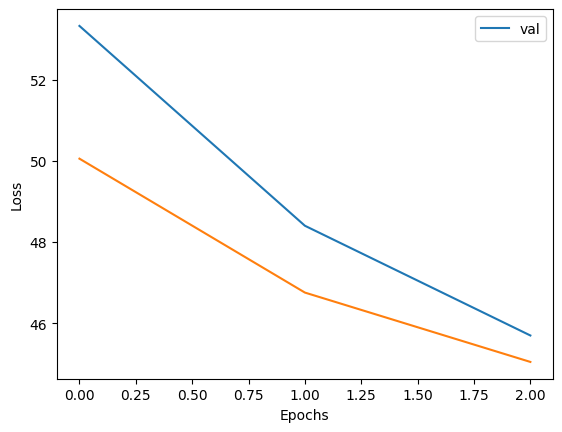

 40%|████      | 2/5 [00:16<00:25,  8.39s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  45.68374991416931
TEST TEST TIME 0.3127601146697998

 Experiment 3
Epoch n0



1it [00:00,  6.11it/s]
2it [00:00,  6.30it/s]
3it [00:00,  6.28it/s]
4it [00:00,  6.05it/s]
5it [00:00,  6.30it/s]
6it [00:00,  6.38it/s]
7it [00:01,  6.25it/s]
8it [00:01,  6.42it/s]
9it [00:01,  6.12it/s]
10it [00:01,  6.10it/s]
11it [00:01,  6.19it/s]
12it [00:01,  6.20it/s]
13it [00:02,  6.16it/s]
15it [00:02,  6.40it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 54.20629056294759
TRAINING TIME 2.3463921546936035
TOTAL VAL LOSS 51.43097162246704
EVAL TIME 0.11924099922180176
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  6.65it/s]
2it [00:00,  6.69it/s]
3it [00:00,  6.55it/s]
4it [00:00,  5.07it/s]
5it [00:00,  5.50it/s]
6it [00:01,  5.73it/s]
7it [00:01,  5.83it/s]
8it [00:01,  6.00it/s]
9it [00:01,  5.83it/s]
10it [00:01,  5.82it/s]
11it [00:01,  5.94it/s]
12it [00:02,  5.95it/s]
13it [00:02,  5.89it/s]
15it [00:02,  5.96it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 49.48904546101888
TRAINING TIME 2.5182459354400635
TOTAL VAL LOSS 47.36083507537842
EVAL TIME 0.12572813034057617
** ** * Saving fine - tuned model ** ** * 


Epoch n2



1it [00:00,  6.10it/s]
2it [00:00,  6.17it/s]
3it [00:00,  6.21it/s]
4it [00:00,  5.87it/s]
5it [00:00,  6.09it/s]
6it [00:00,  6.07it/s]
7it [00:01,  6.10it/s]
8it [00:01,  6.24it/s]
9it [00:01,  5.97it/s]
10it [00:01,  5.95it/s]
11it [00:01,  6.03it/s]
12it [00:01,  6.10it/s]
13it [00:02,  6.04it/s]
15it [00:02,  6.24it/s]


TOTAL TRAIN LOSS 46.05740133921305
TRAINING TIME 2.4063291549682617
TOTAL VAL LOSS 44.26625967025757
EVAL TIME 0.1180570125579834
** ** * Saving fine - tuned model ** ** * 


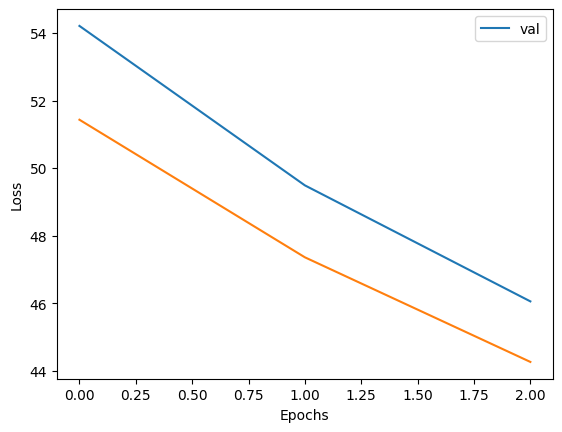

 60%|██████    | 3/5 [00:25<00:16,  8.38s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  45.70626974105835
TEST TEST TIME 0.40111303329467773

 Experiment 4
Epoch n0



1it [00:00,  6.45it/s]
2it [00:00,  6.37it/s]
3it [00:00,  6.23it/s]
4it [00:00,  6.21it/s]
5it [00:00,  6.20it/s]
6it [00:00,  6.06it/s]
7it [00:01,  6.16it/s]
8it [00:01,  6.23it/s]
9it [00:01,  5.71it/s]
10it [00:01,  5.72it/s]
11it [00:01,  5.85it/s]
12it [00:01,  6.02it/s]
13it [00:02,  6.08it/s]
15it [00:02,  5.53it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 54.32110055287679
TRAINING TIME 2.715121269226074
TOTAL VAL LOSS 51.163904666900635
EVAL TIME 0.1022801399230957
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  7.28it/s]
2it [00:00,  6.99it/s]
3it [00:00,  6.60it/s]
4it [00:00,  6.53it/s]
5it [00:00,  6.44it/s]
6it [00:00,  6.30it/s]
7it [00:01,  6.26it/s]
8it [00:01,  6.21it/s]
9it [00:01,  5.69it/s]
10it [00:01,  5.66it/s]
11it [00:01,  5.79it/s]
12it [00:01,  5.98it/s]
13it [00:02,  6.10it/s]
15it [00:02,  6.13it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 49.390356381734215
TRAINING TIME 2.4474687576293945
TOTAL VAL LOSS 46.72515153884888
EVAL TIME 0.10823988914489746
** ** * Saving fine - tuned model ** ** * 


Epoch n2



1it [00:00,  6.88it/s]
2it [00:00,  6.68it/s]
3it [00:00,  6.39it/s]
4it [00:00,  6.35it/s]
5it [00:00,  6.33it/s]
6it [00:00,  6.19it/s]
7it [00:01,  6.21it/s]
8it [00:01,  6.30it/s]
9it [00:01,  5.86it/s]
10it [00:01,  5.84it/s]
11it [00:01,  5.90it/s]
12it [00:01,  6.08it/s]
13it [00:02,  6.04it/s]
15it [00:02,  6.12it/s]


TOTAL TRAIN LOSS 46.27506764729818
TRAINING TIME 2.4530858993530273
TOTAL VAL LOSS 43.24673652648926
EVAL TIME 0.11120820045471191
** ** * Saving fine - tuned model ** ** * 


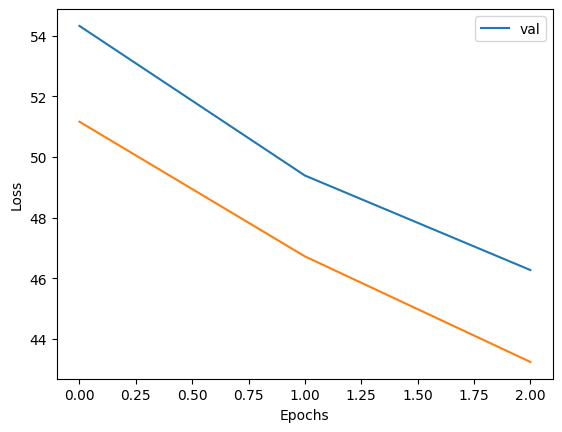

 80%|████████  | 4/5 [00:33<00:08,  8.43s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  44.913833141326904
TEST TEST TIME 0.27080512046813965

 Experiment 5
Epoch n0



1it [00:00,  6.10it/s]
2it [00:00,  6.11it/s]
3it [00:00,  6.02it/s]
4it [00:00,  5.73it/s]
5it [00:00,  5.87it/s]
6it [00:01,  5.22it/s]
7it [00:01,  5.46it/s]
8it [00:01,  4.70it/s]
9it [00:01,  5.10it/s]
10it [00:01,  5.36it/s]
11it [00:02,  5.40it/s]
12it [00:02,  5.67it/s]
13it [00:02,  5.88it/s]
14it [00:02,  5.91it/s]
15it [00:02,  5.71it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 54.15178298950195
TRAINING TIME 2.6275861263275146
TOTAL VAL LOSS 51.08943223953247
EVAL TIME 0.12362313270568848
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  6.45it/s]
2it [00:00,  6.45it/s]
3it [00:00,  6.24it/s]
4it [00:00,  5.75it/s]
5it [00:00,  5.95it/s]
6it [00:01,  5.42it/s]
7it [00:01,  5.55it/s]
8it [00:01,  5.63it/s]
9it [00:01,  5.70it/s]
10it [00:01,  5.76it/s]
11it [00:01,  5.72it/s]
12it [00:02,  5.83it/s]
13it [00:02,  5.84it/s]
14it [00:02,  6.03it/s]
15it [00:02,  5.97it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 49.33018779754639
TRAINING TIME 2.5153417587280273
TOTAL VAL LOSS 47.600743770599365
EVAL TIME 0.12361431121826172
** ** * Saving fine - tuned model ** ** * 


Epoch n2



1it [00:00,  6.49it/s]
2it [00:00,  6.41it/s]
3it [00:00,  6.22it/s]
4it [00:00,  5.78it/s]
5it [00:00,  5.86it/s]
6it [00:01,  5.29it/s]
7it [00:01,  5.49it/s]
8it [00:01,  5.68it/s]
9it [00:01,  5.79it/s]
10it [00:01,  5.82it/s]
11it [00:01,  5.74it/s]
12it [00:02,  5.93it/s]
13it [00:02,  6.05it/s]
14it [00:02,  6.15it/s]
15it [00:02,  6.00it/s]


TOTAL TRAIN LOSS 46.32884661356608
TRAINING TIME 2.5028719902038574
TOTAL VAL LOSS 44.78585958480835
EVAL TIME 0.1369340419769287
** ** * Saving fine - tuned model ** ** * 


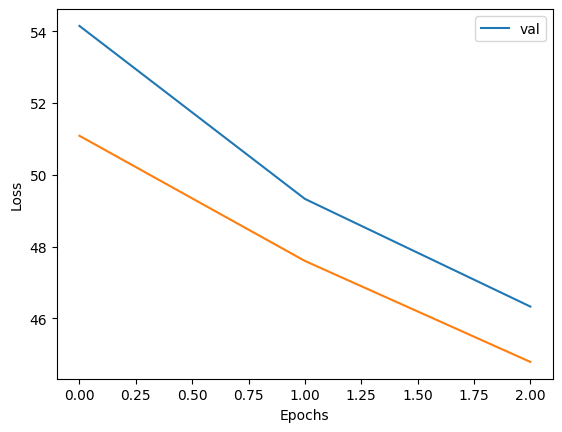

100%|██████████| 5/5 [00:42<00:00,  8.48s/it]

TOTAL TEST LOSS  44.48101997375488
TEST TEST TIME 0.3032209873199463


In [16]:
df = experiment(num_experiments=5)

In [17]:
df

,Experiment,Model,Metric,Score
0,1,GT_BERT,Train Loss,46.113325
1,1,GT_BERT,Val Loss,43.763232
2,1,GT_BERT,Train Time,2.562094
3,1,GT_BERT,Val Time,0.115857
4,1,GT_BERT,Test Time,0.291162
5,1,GT_BERT,Test Loss,36.009641
6,2,GT_BERT,Train Loss,45.697230
7,2,GT_BERT,Val Loss,45.045536
8,2,GT_BERT,Train Time,2.415346
9,2,GT_BERT,Val Time,0.115751


In [18]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# Print the result
print(result_df)

     Model      Metric  Average Score  Standard Deviation
0  GT_BERT   Test Loss          36.13                0.42
1  GT_BERT   Test Time           0.32                0.05
2  GT_BERT  Train Loss          46.09                0.25
3  GT_BERT  Train Time           2.47                0.06
4  GT_BERT    Val Loss          44.22                0.73
5  GT_BERT    Val Time           0.12                0.01


In [19]:
# saving results
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_2.csv')